In [1]:
import numpy as np
import json
import subprocess

In [2]:
dir = '/media/psf/Home/Dropbox/Mac/Documents/vgdataset/'
paths = {'C0003.MP4':'2019-04-03_07.27.36.json'}

In [3]:
def exec_vg(path,record,offset=None):
    if offset is None:
        cmd = './pixelwise_stabilizer -i ' + path + ' -c ILCE-6500 -l SEL1670Z -j ' + record + ' -z 1.3 -n -a'
    else:
        cmd = './pixelwise_stabilizer -i ' + path + ' -c ILCE-6500 -l SEL1670Z -j ' + record + ' -z 1.3 -n -a -x frame_offset_' + format(offset,'1.4f') + '.json'
    
    res = None
    try:
        res = subprocess.check_call(cmd.split(),cwd="../build/")
    except:
        print("Error.")
    print(res)

In [4]:

from cProfile import label
import csv
import matplotlib.pyplot as plt

def openCSV(path):
    with open(path, 'r') as f:
        reader = csv.reader(f)
        header = next(reader)  # ヘッダー行を読み飛ばし

        data = []
        for row in reader:
            data.append(row)

    legends = [i for i in header]
    data = [[float(i) for i in row] for row in data]  # 文字列を数値に変換

    # X軸に時間を、Y軸にデータをセット
    eavf = [row[legends.index('Estimated angular velocity frame')] for row in data]
    mavf = [row[legends.index('Measured angular velocity frame')] for row in data]
    a = [row[legends.index('a-skew')] for row in data]
    b = [row[legends.index('b-offset')] for row in data]
    return eavf,mavf,a,b

In [5]:
def plotSync(x,y,labelx,labely,title):
    plt.figure(figsize=(10,6))
    plt.plot(x,y,'bo-')
    plt.xlabel(labelx)
    plt.ylabel(labely)          
    # plt.legend()
    plt.title(title)
    plt.grid()    
    plt.show()

0
/media/psf/Home/Dropbox/Mac/Documents/vgdataset/C0003.MP4 /media/psf/Home/Dropbox/Mac/Documents/vgdataset/2019-04-03_07.27.36.json


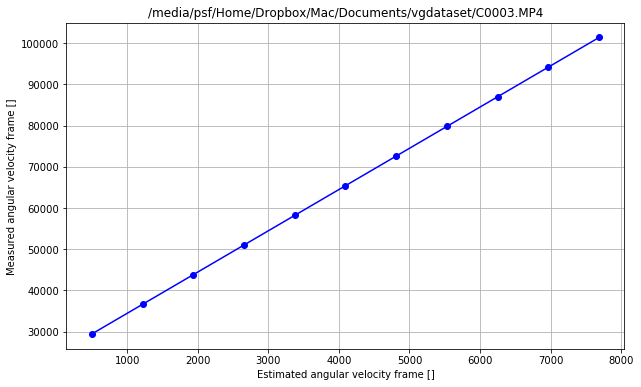

In [12]:
for p, r in paths.items():
    exec_vg(dir+p,dir+r)
    print(dir+p,dir+r)
    eavf,mavf,a,b = openCSV('../build/latest_sync_table.csv')
    plotSync(eavf,mavf,'Estimated angular velocity frame []','Measured angular velocity frame []',dir+p)
    

In [13]:
mavf

[29437.332925,
 36634.876278,
 43832.303515,
 51029.829851,
 58227.175006,
 65424.566207,
 72622.161612,
 79819.628889,
 87017.072142,
 94214.357237,
 101411.903593]

In [14]:
frame_offsets=np.linspace(-2.0,2.0,21)

for fo in frame_offsets:
    with open('../build/frame_offset_' + format(fo,'1.4f') + '.json', 'w') as f:
        obj={"frame_offset":fo, "path_prefix":format(fo,'1.4f')}
        json.dump(obj, f)

for p, r in paths.items():
    for fo in frame_offsets:
        exec_vg(dir+p,dir+r,fo)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [6]:

from cProfile import label
import csv
import matplotlib.pyplot as plt

def openCSV(path):
    with open(path, 'r') as f:
        reader = csv.reader(f)
        header = next(reader)  # ヘッダー行を読み飛ばし

        data = []
        for row in reader:
            data.append(row)

    legends = [i for i in header]
    data = [[float(i) for i in row] for row in data]  # 文字列を数値に変換
    # data = [print(row) for row in data]  # 文字列を数値に変換
    # X軸に時間を、Y軸にデータをセット
    t = [row[legends.index('Frame')] for row in data]
    rxw = [row[legends.index('rx')] for row in data]
    ryw = [row[legends.index('ry')] for row in data]
    rzw = [row[legends.index('rz')] for row in data]
    return t, rxw, ryw, rzw

# 角加速度を計算する関数を定義。戻り値の配列の長さが元の配列より１短い事に注意。
import numpy as np

def getAngularAcceleration(angular_velocity, sampling_rate):
    return (np.array(angular_velocity)[1:]-np.array(angular_velocity)[:-1])*sampling_rate

def getAverageOfAbsAngularAcceleration(angular_velocity, sampling_rate):
    return np.average(np.abs(getAngularAcceleration(angular_velocity,sampling_rate)))

def getTime(angular_velocity,sampling_rate):
    return np.linspace(0,len(angular_velocity)-1,len(angular_velocity))/sampling_rate

def getA4(angular_velocity,sampling_rate, length):
    time = getTime(angular_velocity,sampling_rate)
    a4 = []
    time_average = []
    for i in range(0,len(angular_velocity),length):
        a4.append(getAverageOfAbsAngularAcceleration(angular_velocity[i:i+length],sampling_rate))
        time_average.append(np.average(time[i:i+length])) 
    return time_average, a4

def plotA4s(angular_velocitys,legends=None, sampling_rate=30., length=50,xlim=None,ylim=None):
    plt.figure(figsize=(12,6))

    if legends is not None:
        for av,lb in zip(angular_velocitys,legends):
            time_average, a4 = getA4(av,sampling_rate,length)
            plt.plot(time_average,a4,label=lb)
    else:
        for av in angular_velocitys:
            time_average, a4 = getA4(av,sampling_rate,length)
            plt.plot(time_average,a4)

    if xlim is not None:
        plt.xlim(xlim[0],xlim[1])
    if ylim is not None:
        plt.ylim(ylim[0],ylim[1])
    plt.xlabel('Time [second]')
    plt.ylabel('Average of Angular Acceleration [rad/s^2]')          
    plt.legend()
    plt.grid()




In [7]:
def plotRelativeA4s(angular_velocitys,original_angular_velocity,legends=None, sampling_rate=30., length=50,xlim=None,ylim=None):

    plt.figure(figsize=(10,6))

    if legends is not None:
        for av,oav,lb in zip(angular_velocitys,original_angular_velocity,legends):
            time_average, a4 = getA4(av,sampling_rate,length)
            time_average, oa4 = getA4(oav,sampling_rate,length)
            if lb == 'x_0.0000':
                plt.plot(time_average,np.array(a4)/(np.array(oa4)+0.001),'--',label=lb,)
            else:
                print(np.shape(time_average))
                print(np.shape(np.array(a4)))
                print(np.shape(np.array(oa4)))
                plt.plot(time_average,np.array(a4)/(np.array(oa4)+0.001),label=lb)
    else:
        for av,oav in zip(angular_velocitys,original_angular_velocity):
            time_average, a4 = getA4(av,sampling_rate,length)
            time_average, oa4 = getA4(oav,sampling_rate,length)
            plt.plot(time_average,np.array(a4)/(np.array(oa4)+0.001))
    


    if xlim is not None:
        plt.xlim(xlim[0],xlim[1])
    if ylim is not None:
        plt.ylim(ylim[0],ylim[1])
    plt.xlabel('Time [second]')
    plt.ylabel('Reduction ratio [ ]')     
    if legends is not None:     
        plt.legend()
    plt.grid()

In [10]:
# 時系列方向のreduction ratioをまず表示。offset = 0のデータで良い。
frame_offsets=np.linspace(-2.0,2.0,21)
legend = []
datas = None
for fo in frame_offsets:
    numstr = format(fo,'1.4f')
    # CSVを開く
    data = openCSV('../build/' + numstr + '_warped_estimated_angular_velocity.csv')
    # legendを書く
    legend.append('x_' + numstr)
    # legend.append('y_' + numstr)
    # legend.append('z_' + numstr)
    
    # データを結合する
    if datas is None:
        datas = data[1:] # X axis only
    else:
        datas = np.append(datas,data[1:],axis=0) # X axis only

# legend = []
original_datas = None
for fo in frame_offsets:
    numstr = format(fo,'1.4f')
    # CSVを開く
    data = openCSV('../build/latest_estimated_angular_velocity.csv')
    # legendを書く
    # legend.append('x_' + numstr)
    # legend.append('y_' + numstr)
    # legend.append('z_' + numstr)
    

    # データを結合する
    if original_datas is None:
        original_datas = data[1:]
    else:
        original_datas = np.append(original_datas,data[1:],axis=0)

print(np.shape(datas),'AAAA')
print(np.shape(original_datas))
plotRelativeA4s(datas,original_datas, sampling_rate=30.,legends=legend,length=30,xlim=[0,20],ylim=[0,2])

(63, 2315) AAAA
(63, 9108)
(304,)
(78,)
(304,)


ValueError: operands could not be broadcast together with shapes (78,) (304,) 

<Figure size 720x432 with 0 Axes>

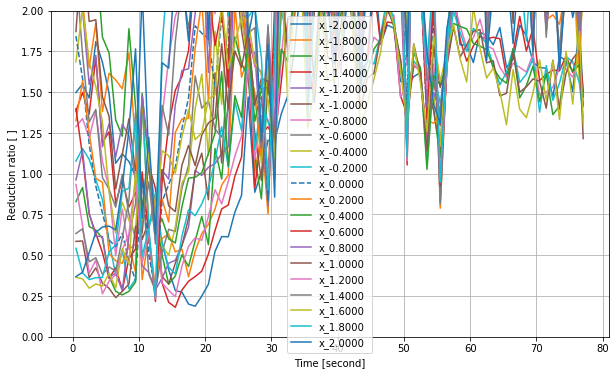

In [ ]:
plotRelativeA4s(datas,original_datas, sampling_rate=30.,legends=legend,length=30,ylim=[0,2])

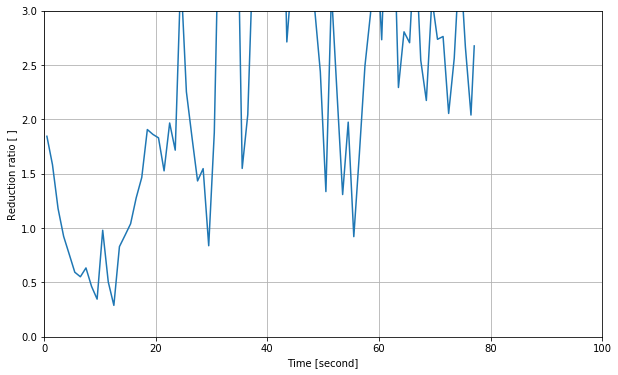

In [ ]:
plotRelativeA4s([datas[int(datas.shape[0]/2)]],[original_datas[int(original_datas.shape[0]/2)]], sampling_rate=30.,length=30,xlim=[0,100],ylim=[0,3])

In [ ]:
def getAverageRelativeA4s(angular_velocitys,original_angular_velocity,frame_offset,legends=None, sampling_rate=30., length=50,xlim=None,ylim=None):

    ratio = []

    if legends is not None:
        for av,oav,lb in zip(angular_velocitys,original_angular_velocity,legends):
            time_average, a4 = getA4(av,sampling_rate,length)
            time_average, oa4 = getA4(oav,sampling_rate,length)
            # plt.plot(time_average,np.array(a4)/(np.array(oa4)+0.001),label=lb)
            ratio.append(np.average(a4)/np.average(oa4))
    else:
        for av,oav in zip(angular_velocitys,original_angular_velocity):
            time_average, a4 = getA4(av,sampling_rate,length)
            time_average, oa4 = getA4(oav,sampling_rate,length)
            # plt.plot(time_average,np.array(a4)/(np.array(oa4)+0.001))
            ratio.append(np.average(a4)/np.average(oa4))
        


    rsratio = np.reshape(np.array(ratio),(int(len(ratio)/3),3))

    
    return rsratio

In [ ]:
min_red_tatio = []
ave_frame = []
# length = 200
length = 100
for i in range(0,len(datas[0])-1-length,length):
    red_ratio = getAverageRelativeA4s(datas[:,i:i+length],original_datas[:,i:i+length], frame_offset=frame_offsets, sampling_rate=30.,length=20)
    print(min(red_ratio[:,0]))
    if min(red_ratio[:,0]) is np.NaN:
        print(red_ratio)
    x_axis_ratio = red_ratio[:,0]
    x_axis_min_value_index = np.argmin(x_axis_ratio)
    
    min_red_tatio.append(frame_offsets[x_axis_min_value_index])
    ave_frame.append((i + length/2))

0.32157205309409653
0.3452989221836647
0.28193136306005234
0.8680058112104453
0.2467982891287171
0.2165116957936717
0.5225107688277146
0.8063403501246544
1.0301759267386075
1.3940790464794857
1.7249540535769352
1.6717946282607328
1.8970811332934452
1.5350952324068787
1.8285244973909671
1.4974999216059195
1.3829211369982477
1.7175201250486374
1.7356944232007683
1.4720616264294786
1.4404570107055856
1.3924068961954577
1.5397177219992342


<ipython-input-91-5da43481ed63>:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  a,b = np.linalg.lstsq(A,min_red_tatio)[0]


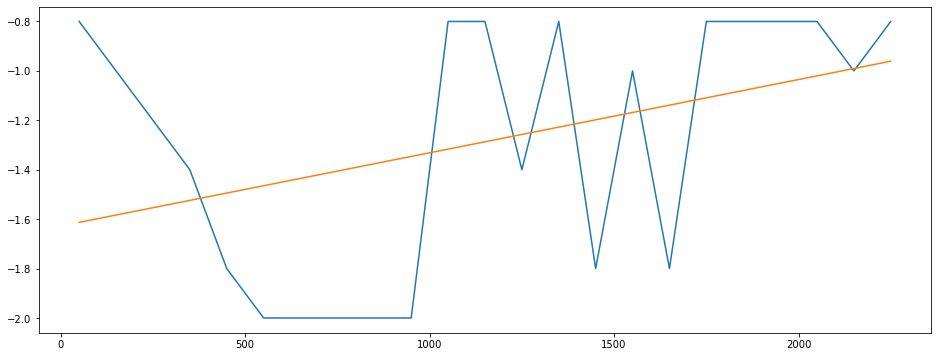

In [ ]:
# 角加速度が最小となる時刻オフセット
A = np.array([ave_frame,np.ones(len(ave_frame))])
A = A.T
a,b = np.linalg.lstsq(A,min_red_tatio)[0]

plt.figure(figsize=(16,6))
plt.plot(ave_frame,min_red_tatio)
plt.plot(ave_frame,(a*np.array(ave_frame)+b))

In [ ]:
import pprint

In [ ]:
def plotAverageRelativeA4sNew(angular_velocitys,original_angular_velocitys,frame_offset,legends=None, sampling_rate=30., length=50,xlim=None,ylim=None):
    
    plt.figure(figsize=(10,6))

    for i in range(0,len(angular_velocitys[0])-1,length):
        # print(i,i+length)
        div_angular_velocity = angular_velocitys[:,i:i+length]
        div_original_angular_velocity = original_angular_velocitys[:,i:i+length]
        
        ratio = []

        if legends is not None:
            for av,oav,lb in zip(div_angular_velocity,div_original_angular_velocity,legends):

                time_average, a4 = getA4(av,sampling_rate,length)
                time_average, oa4 = getA4(oav,sampling_rate,length)
                # print(a4)
                # print(oa4)
                ratio.append(np.average(a4)/(np.average(oa4)+0.0001))
            if i < 10*length:
                plt.plot(frame_offset,ratio,label=str(i))
            elif i < 20*length:
                plt.plot(frame_offset,ratio,'--',label=str(i))
            elif i < 30*length:
                plt.plot(frame_offset,ratio,'+',label=str(i))
            else:
                plt.plot(frame_offset,ratio,'o',label=str(i))
        else:
            for av,oav in zip(div_angular_velocity,div_original_angular_velocity):
                time_average, a4 = getA4(av,sampling_rate,length)
                time_average, oa4 = getA4(oav,sampling_rate,length)
                ratio.append(np.average(a4)/(np.average(oa4)+0.0001))
            plt.plot(frame_offset,ratio)

        # print('ratio',ratio)
        # rsratio = np.reshape(np.array(ratio),(int(len(ratio)/3),3))

        # print('frame_offset',frame_offset)
        # print('rsratio[:,0]',rsratio[:,0])
        # plt.plot(frame_offset,rsratio[:,0])
        
        

    if xlim is not None:
        plt.xlim(xlim[0],xlim[1])
    if ylim is not None:
        plt.ylim(ylim[0],ylim[1])
    plt.xlabel('Frame [ ]')
    plt.ylabel('Reduction ratio [ ]')   
    if legends is not None:          
        plt.legend()
    plt.grid()
    plt.show()


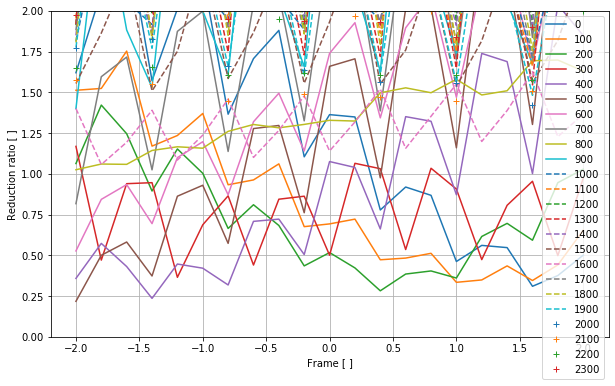

In [ ]:
plotAverageRelativeA4sNew(datas,original_datas, frame_offsets, sampling_rate=30.,legends=legend,length=100,ylim=[0,2])